<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

<Ответ>

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

<Ответ>

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

<Ответ>

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

<Ответ>


**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

<Ответ>

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

<Ответ>

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline.

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
!tar -xvzf data.tar.gz

data/caption_tokens.pcl
data/
data/image_codes.npy
data/raw_captions.pcl
data/Dog-and-Cat.jpg
data/blvc_googlenet.pkl


### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 4.01 s, sys: 400 ms, total: 4.41 s
Wall time: 4.41 s


In [3]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [4]:
# split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"] + sentence.split(' ') + ["#END#"]

In [5]:
import collections

In [6]:
flattened_captions = [item for sublist in captions for subsublist in sublist for item in subsublist]

In [7]:
len(captions)

123287

In [8]:
len(flattened_captions)

7687649

In [9]:
# Build a Vocabulary

############# TO CODE IT BY YOURSELF ##################
word_counts = dict(collections.Counter(flattened_captions))

vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [10]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32') + PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [11]:
# try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 9003,  5799,  5401,  8257,  9774,  5271,  9281,  9707,  3233,
         2511,  7975,  2167,  4976,    -1,    -1],
       [ 9003,  3233,  2511,  9940,  2050,  7917,  2167,  7975,  6211,
         1408,  9281,  4976,    -1,    -1,    -1],
       [ 9003,  7201,  8257,  9774,  5271,  9281,  9707,  3233,  5856,
         7028,  1001,   634,  3122, 10361,  4976],
       [ 9003,  7201,  9849,  6199,   848,  9704,  7201,  9849,  3185,
         4976,    -1,    -1,    -1,    -1,    -1],
       [ 9003,  5799,  5401,  8257,  9774,  5271,  9281,  9707,  3233,
         2511,  1001,   634,  7605,  4976,    -1]], dtype=int32)

### Mah Neural Network

In [12]:
# network shapes
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 # pls change me if u want
LSTM_UNITS = 200 # pls change me if u want

In [13]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

In [14]:
# Input Variable
sentences = T.imatrix() # [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [15]:
# network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

# embeddings for words 
############# TO CODE IT BY YOURSELF ##################
l_word_embeddings = EmbeddingLayer(l_words, n_tokens, EMBED_SIZE)

In [16]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
# convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
# it's also a good idea to add some dropout here and there

# l_image_features_small = <Apply Dropout Layer to regularise your Net>
# l_image_features_small = <Apply Dense to acive LSTM_UNITS size of representation>
l_image_features_small = DropoutLayer(l_image_features)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)

assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [17]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 

# decoder = LSTMLayer(<Hmmm, what whould be here?>,
#                     num_units=LSTM_UNITS,
#                     cell_init=<Use your brain =)>,
#                     mask_input=<Mask?>,
#                     grad_clipping=<boom grads>)
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=10)

In [18]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

# apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ", broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

# un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

# remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 200)
output shape =  (None, None, 10373)


In [19]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

# write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
# loss = <mean over non-PAD tokens>

loss = (loss * output_mask).mean()

In [20]:
# trainable NN weights
############# TO CODE IT BY YOURSELF ##################
# weights = <all dnn weigts>

weights = lasagne.layers.get_all_params(predicted_probabilities, trainable=True)
updates = lasagne.updates.adam(loss, weights)

In [21]:
# compile a function that takes input sentence and image mask, outputs loss and updates weights
# please NOTE that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################

train_step = theano.function([image_vectors, sentences], loss, updates=updates, allow_input_downcast=True)
val_step   = theano.function([image_vectors, sentences], loss, allow_input_downcast=True)

/home/ec2-user/anaconda2/lib/python2.7/site-packages/theano/tensor/basic.py:5130: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [22]:
captions = np.array(captions)

In [23]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    # sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    # get images
    batch_images = images[random_image_ix]
    
    # 5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    # pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    # convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [24]:
generate_batch(img_codes,captions, 3)

(array([[-0.91454536, -0.78876424, -0.4597505 , ..., -2.12854791,
          1.2505604 , -1.64951837],
        [-1.22799468, -2.54519629, -2.57619119, ..., -0.68599069,
          2.78016186,  2.27345657],
        [-6.10443354, -2.41867566, -0.9958238 , ..., -2.36595058,
          0.08055237,  3.38364458]], dtype=float32),
 array([[9003, 9570, 9707, 7201, 9763, 7975, 7529, 9707, 7201,  655, 4976,
           -1],
        [9003, 7201, 7142, 3834, 7060, 1135, 7201, 1272, 9704, 6722, 9115,
         4976],
        [9003, 8141, 7162,  831, 7125, 1977, 6100, 7201, 5759, 5012, 4976,
           -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [25]:
batch_size = 50 # adjust me
n_epochs   = 100 # adjust me
n_batches_per_epoch = 50 # adjust me
n_validation_batches = 5 # how many batches are used for validation after each epoch

In [26]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0, train loss: 3.82504069567, val loss: 3.71935863495


  2%|▏         | 1/50 [00:00<00:06,  7.38it/s]


Epoch: 1, train loss: 3.10119680882, val loss: 3.09953393936


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 3.12063171387, val loss: 3.07488789558


  2%|▏         | 1/50 [00:00<00:05,  8.22it/s]


Epoch: 3, train loss: 2.93017641544, val loss: 2.73873729706


  2%|▏         | 1/50 [00:00<00:07,  6.17it/s]


Epoch: 4, train loss: 2.82765829563, val loss: 2.6715139389


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 2.83171657562, val loss: 2.61730570793


  2%|▏         | 1/50 [00:00<00:05,  8.23it/s]


Epoch: 6, train loss: 2.60623774529, val loss: 2.34278712273


  2%|▏         | 1/50 [00:00<00:05,  9.39it/s]


Epoch: 7, train loss: 2.41352432728, val loss: 2.62927508354


  4%|▍         | 2/50 [00:00<00:04, 11.99it/s]


Epoch: 8, train loss: 2.43726049185, val loss: 2.6214384079


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 9, train loss: 2.43460390568, val loss: 2.06261556149


  4%|▍         | 2/50 [00:00<00:03, 12.03it/s]


Epoch: 10, train loss: 2.27743535519, val loss: 2.21921679974


  4%|▍         | 2/50 [00:00<00:04, 10.79it/s]


Epoch: 11, train loss: 2.30214481115, val loss: 2.31445057392


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 12, train loss: 2.30774167538, val loss: 2.39901497364


  4%|▍         | 2/50 [00:00<00:04, 10.11it/s]


Epoch: 13, train loss: 2.31807983875, val loss: 1.96536874771


  2%|▏         | 1/50 [00:00<00:08,  5.60it/s]


Epoch: 14, train loss: 2.30772123575, val loss: 2.18210086823


  2%|▏         | 1/50 [00:00<00:05,  9.28it/s]


Epoch: 15, train loss: 2.18216476917, val loss: 2.47540092468


  2%|▏         | 1/50 [00:00<00:06,  7.38it/s]


Epoch: 16, train loss: 2.24249365568, val loss: 2.15081217289


  2%|▏         | 1/50 [00:00<00:06,  8.14it/s]


Epoch: 17, train loss: 2.07082366705, val loss: 2.27490353584


  2%|▏         | 1/50 [00:00<00:05,  8.79it/s]


Epoch: 18, train loss: 2.11986889601, val loss: 1.93163709641


  4%|▍         | 2/50 [00:00<00:04, 11.96it/s]


Epoch: 19, train loss: 2.11400832653, val loss: 2.06844472885


  2%|▏         | 1/50 [00:00<00:05,  9.66it/s]


Epoch: 20, train loss: 2.0522157836, val loss: 1.8450240612


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 21, train loss: 2.09511016607, val loss: 2.11451237202


  2%|▏         | 1/50 [00:00<00:07,  6.81it/s]


Epoch: 22, train loss: 2.13779526234, val loss: 2.16868343353


  4%|▍         | 2/50 [00:00<00:04, 10.92it/s]


Epoch: 23, train loss: 1.99484671593, val loss: 2.24032211304


  2%|▏         | 1/50 [00:00<00:05,  9.09it/s]


Epoch: 24, train loss: 2.10959933519, val loss: 2.26827850342


  2%|▏         | 1/50 [00:00<00:05,  8.94it/s]


Epoch: 25, train loss: 2.05752300262, val loss: 1.88603479862


  2%|▏         | 1/50 [00:00<00:05,  8.76it/s]


Epoch: 26, train loss: 2.06172613144, val loss: 1.68040835857


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 27, train loss: 1.93031699896, val loss: 2.15502605438


  2%|▏         | 1/50 [00:00<00:05,  9.52it/s]


Epoch: 28, train loss: 1.95723791599, val loss: 1.99361028671


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 29, train loss: 1.91805480003, val loss: 1.92215280533


  2%|▏         | 1/50 [00:00<00:06,  7.71it/s]


Epoch: 30, train loss: 1.95872086763, val loss: 2.18895900249


  2%|▏         | 1/50 [00:00<00:05,  9.43it/s]


Epoch: 31, train loss: 1.99993801951, val loss: 2.0018112421


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 1.98950079441, val loss: 1.89095232487


  2%|▏         | 1/50 [00:00<00:05,  9.42it/s]


Epoch: 33, train loss: 1.9816287303, val loss: 1.65501804352


  2%|▏         | 1/50 [00:00<00:07,  7.00it/s]


Epoch: 34, train loss: 1.87842972279, val loss: 2.04817945957


  2%|▏         | 1/50 [00:00<00:05,  8.90it/s]


Epoch: 35, train loss: 1.87994109869, val loss: 1.84060242176


  2%|▏         | 1/50 [00:00<00:05,  9.78it/s]


Epoch: 36, train loss: 1.97072121143, val loss: 2.11926460266


  2%|▏         | 1/50 [00:00<00:06,  7.94it/s]


Epoch: 37, train loss: 1.96304433107, val loss: 1.72491514683


  2%|▏         | 1/50 [00:00<00:06,  7.05it/s]


Epoch: 38, train loss: 1.92762013435, val loss: 1.83389997482


  2%|▏         | 1/50 [00:00<00:06,  7.05it/s]


Epoch: 39, train loss: 1.83854412436, val loss: 1.76430640221


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 40, train loss: 1.73108586192, val loss: 1.94934117794


  2%|▏         | 1/50 [00:00<00:05,  9.60it/s]


Epoch: 41, train loss: 1.91697420955, val loss: 1.71614961624


  2%|▏         | 1/50 [00:00<00:05,  8.28it/s]


Epoch: 42, train loss: 1.88910864115, val loss: 1.96708126068


  2%|▏         | 1/50 [00:00<00:05,  9.48it/s]


Epoch: 43, train loss: 1.95513357878, val loss: 2.14230964184


  2%|▏         | 1/50 [00:00<00:06,  7.42it/s]


Epoch: 44, train loss: 1.96296976566, val loss: 1.88757061958


  2%|▏         | 1/50 [00:00<00:05,  8.40it/s]


Epoch: 45, train loss: 1.88138548851, val loss: 2.11023955345


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 46, train loss: 1.86078645706, val loss: 1.81337752342


  4%|▍         | 2/50 [00:00<00:04, 10.56it/s]


Epoch: 47, train loss: 1.87769233704, val loss: 1.88431591988


  2%|▏         | 1/50 [00:00<00:05,  9.47it/s]


Epoch: 48, train loss: 1.82990748167, val loss: 1.70646393299


  2%|▏         | 1/50 [00:00<00:05,  8.98it/s]


Epoch: 49, train loss: 1.73562461853, val loss: 1.81647503376


  4%|▍         | 2/50 [00:00<00:04, 11.17it/s]


Epoch: 50, train loss: 1.8049394691, val loss: 1.73955826759


  2%|▏         | 1/50 [00:00<00:05,  9.46it/s]


Epoch: 51, train loss: 1.85807582259, val loss: 1.78920896053


  4%|▍         | 2/50 [00:00<00:04, 10.51it/s]


Epoch: 52, train loss: 1.71691611528, val loss: 1.40639057159


  4%|▍         | 2/50 [00:00<00:04, 11.63it/s]


Epoch: 53, train loss: 1.83260252953, val loss: 1.60388371944


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 54, train loss: 1.77218820333, val loss: 2.051577878


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 55, train loss: 1.75824731112, val loss: 1.68083524704


  4%|▍         | 2/50 [00:00<00:04, 10.42it/s]


Epoch: 56, train loss: 1.83615142345, val loss: 1.99738788605


  2%|▏         | 1/50 [00:00<00:05,  8.36it/s]


Epoch: 57, train loss: 1.8340991497, val loss: 1.87723557949


  2%|▏         | 1/50 [00:00<00:06,  8.05it/s]


Epoch: 58, train loss: 1.81454064369, val loss: 1.82525444031


  2%|▏         | 1/50 [00:00<00:05,  9.67it/s]


Epoch: 59, train loss: 1.8284620142, val loss: 1.69647912979


  2%|▏         | 1/50 [00:00<00:08,  5.99it/s]


Epoch: 60, train loss: 1.75915320516, val loss: 1.59819638729


  4%|▍         | 2/50 [00:00<00:04, 11.94it/s]


Epoch: 61, train loss: 1.87851080656, val loss: 1.67478995323


  2%|▏         | 1/50 [00:00<00:07,  6.91it/s]


Epoch: 62, train loss: 1.75523887515, val loss: 1.91968522072


  2%|▏         | 1/50 [00:00<00:07,  6.78it/s]


Epoch: 63, train loss: 1.77682256579, val loss: 1.71977777481


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 64, train loss: 1.81893988132, val loss: 1.81325159073


  2%|▏         | 1/50 [00:00<00:05,  9.51it/s]


Epoch: 65, train loss: 1.74557970762, val loss: 1.79787118435


  4%|▍         | 2/50 [00:00<00:04, 10.95it/s]


Epoch: 66, train loss: 1.74178448796, val loss: 1.73751380444


  2%|▏         | 1/50 [00:00<00:06,  7.50it/s]


Epoch: 67, train loss: 1.72866125226, val loss: 1.92676427364


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 68, train loss: 1.82924497604, val loss: 1.75683963299


  2%|▏         | 1/50 [00:00<00:05,  8.83it/s]


Epoch: 69, train loss: 1.72715359926, val loss: 1.64036874771


  4%|▍         | 2/50 [00:00<00:04, 10.72it/s]


Epoch: 70, train loss: 1.84765938997, val loss: 1.88017377853


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 71, train loss: 1.72500319481, val loss: 1.60626394749


  4%|▍         | 2/50 [00:00<00:04, 10.49it/s]


Epoch: 72, train loss: 1.79352749467, val loss: 1.72006075382


  2%|▏         | 1/50 [00:00<00:05,  8.43it/s]


Epoch: 73, train loss: 1.7457857573, val loss: 1.7263876915


  2%|▏         | 1/50 [00:00<00:06,  7.99it/s]


Epoch: 74, train loss: 1.73613473654, val loss: 1.72633481026


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 75, train loss: 1.7802623415, val loss: 1.44881802797


  2%|▏         | 1/50 [00:00<00:07,  6.73it/s]


Epoch: 76, train loss: 1.74780679226, val loss: 1.81827321053


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 77, train loss: 1.68150680661, val loss: 1.79611525536


  2%|▏         | 1/50 [00:00<00:04, 10.00it/s]


Epoch: 78, train loss: 1.77217259169, val loss: 1.91891438961


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 79, train loss: 1.7449791348, val loss: 1.57774581909


  2%|▏         | 1/50 [00:00<00:05,  9.17it/s]


Epoch: 80, train loss: 1.71852978706, val loss: 1.60978484154


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 81, train loss: 1.67598481536, val loss: 1.5217061758


  2%|▏         | 1/50 [00:00<00:06,  7.44it/s]


Epoch: 82, train loss: 1.73423272133, val loss: 1.91365549564


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 83, train loss: 1.70921914339, val loss: 1.61968665123


  4%|▍         | 2/50 [00:00<00:04, 10.34it/s]


Epoch: 84, train loss: 1.72775131464, val loss: 1.60831186771


  4%|▍         | 2/50 [00:00<00:03, 12.88it/s]


Epoch: 85, train loss: 1.74182802558, val loss: 1.95405604839


  2%|▏         | 1/50 [00:00<00:05,  9.15it/s]


Epoch: 86, train loss: 1.71769203186, val loss: 1.85613923073


  2%|▏         | 1/50 [00:00<00:05,  8.28it/s]


Epoch: 87, train loss: 1.73256433725, val loss: 1.90044229031


  2%|▏         | 1/50 [00:00<00:04,  9.99it/s]


Epoch: 88, train loss: 1.68200758219, val loss: 1.76056511402


  2%|▏         | 1/50 [00:00<00:04,  9.94it/s]


Epoch: 89, train loss: 1.62923840523, val loss: 1.62381849289


  2%|▏         | 1/50 [00:00<00:07,  6.62it/s]


Epoch: 90, train loss: 1.60880834222, val loss: 1.52657489777


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 91, train loss: 1.65612585545, val loss: 1.76408469677


  4%|▍         | 2/50 [00:00<00:04, 10.50it/s]


Epoch: 92, train loss: 1.71720885754, val loss: 1.70200722218


  2%|▏         | 1/50 [00:00<00:05,  9.71it/s]


Epoch: 93, train loss: 1.69397274494, val loss: 1.81755974293


  2%|▏         | 1/50 [00:00<00:06,  7.53it/s]


Epoch: 94, train loss: 1.70484742403, val loss: 1.6213889122


  2%|▏         | 1/50 [00:00<00:05,  9.04it/s]


Epoch: 95, train loss: 1.66503996968, val loss: 1.84048752785


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 96, train loss: 1.78862133503, val loss: 1.64176039696


  2%|▏         | 1/50 [00:00<00:05,  9.46it/s]


Epoch: 97, train loss: 1.70242389798, val loss: 1.74333555698


  2%|▏         | 1/50 [00:00<00:06,  7.90it/s]


Epoch: 98, train loss: 1.71745239973, val loss: 1.84587152004


100%|██████████| 50/50 [00:06<00:00,  8.42it/s]



Epoch: 99, train loss: 1.60686851263, val loss: 1.57079679966
Finish :)


### apply trained model

In [27]:
# the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

# load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

# compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [28]:
from matplotlib import pyplot as plt
%matplotlib inline

# sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

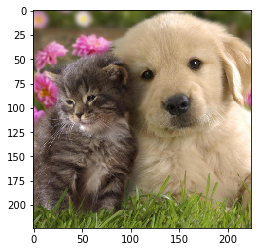

In [29]:
# deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [30]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

# this is exactly the generation function from week5 classwork,
# except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        # apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [34]:
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

there dog a cat sitting at the beach
little dog and cat sleeping wrapped in a window
two brown cat are sitting in a chair on the slats of one cat towards the double dog wearing a black and white dress can touch his claw
cat black dog that polar bear in a small bowl
dog sticking a eyes and a cat on fridge
a cat is sitting at a another table with shower her bird with the second gesture as a dog threw a donkey in a red suit and a white dog
a very cute cat holding a cat in a dog
a black dog next to a cat has his tongue
dog fluffy cat sitting beneath a shower pot
some white image of a large brown dog and large ears of a cat


# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 